In [35]:
import numpy as np
from sb3_contrib import TQC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from single_state_mdp import SingleStateMDP

import matplotlib.pyplot as plt

## V1

In [23]:
def make_env():
    # Define and return an instance of the SingleStateMDP environment
    return SingleStateMDP()

In [29]:
# Create the TQC agent with specified parameters
policy_kwargs = {"n_quantiles": 25, "n_critics": 2, "net_arch": [50,50]}

In [30]:
quantiles_to_drop = [0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 16]
agents = [None] * 11

In [31]:
for i, d in enumerate(quantiles_to_drop):
    env = make_env()
    eval_env = Monitor(make_env())

    agents[i] = TQC("MlpPolicy", env, policy_kwargs=policy_kwargs, top_quantiles_to_drop_per_net=d)
    # Train the agent for the desired number of iterations
    agents[i].learn(total_timesteps=3000)

    # Evaluate the performance of the TQC agent using the evaluate_policy function
    mean_rewards, std_rewards = evaluate_policy(agents[i], eval_env, n_eval_episodes=100)

    print(f'[{d}] {mean_rewards:.3f} +/- {std_rewards:.3f}')

[0] 0.607 +/- 0.280
[1] 0.561 +/- 0.261
[2] 0.608 +/- 0.251
[3] 0.635 +/- 0.250
[4] 0.574 +/- 0.257
[5] 0.593 +/- 0.267
[6] 0.632 +/- 0.233
[7] 0.617 +/- 0.236
[10] 0.586 +/- 0.227
[13] 0.617 +/- 0.235
[16] 0.571 +/- 0.240


In [33]:
points = np.zeros((11,2))

In [34]:
# Define a dense uniform grid of actions to evaluate the approximations on
actions = np.linspace(-1, 1, 2000)

# Initialize arrays to store the results
signed_discrepancies = np.zeros(actions.shape)

for i, agent in enumerate(agents):
    # Evaluate the performance of the TQC agent on the dense uniform grid of actions
    for j, action in enumerate(actions):
        # Get the approximate Q-value for the current action
        q_value, _ = agent.predict(np.array([0]), np.array([action]))
        
        # Calculate the signed discrepancy between the approximate Q-value and the true Q-value
        signed_discrepancy = q_value - env._mean_reward(action)
        
        # Store the results
        signed_discrepancies[j] = signed_discrepancy

    points[i,0] = signed_discrepancies.mean()
    points[i,1] = signed_discrepancies.std()

    print(f'Signed Discrepency: {signed_discrepancies.mean():.3f} +/- {signed_discrepancies.std():.3f}')

Signed Discrepency: 0.104 +/- 0.473
Signed Discrepency: 0.121 +/- 0.472
Signed Discrepency: 0.105 +/- 0.467
Signed Discrepency: 0.113 +/- 0.463
Signed Discrepency: 0.105 +/- 0.474
Signed Discrepency: 0.103 +/- 0.473
Signed Discrepency: 0.110 +/- 0.463
Signed Discrepency: 0.120 +/- 0.478
Signed Discrepency: 0.098 +/- 0.465
Signed Discrepency: 0.091 +/- 0.473
Signed Discrepency: 0.105 +/- 0.467


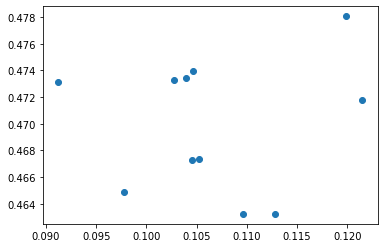

In [36]:
plt.scatter(points[:,0], points[:,1])

## V2

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from single_state_mdp import SingleStateMDP
import random

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def quantile_huber_loss_f(quantiles, samples):
    pairwise_delta = samples[:, None, None, :] - quantiles[:, :, :, None]  # batch x nets x quantiles x samples
    abs_pairwise_delta = torch.abs(pairwise_delta)
    huber_loss = torch.where(abs_pairwise_delta > 1,
                             abs_pairwise_delta - 0.5,
                             pairwise_delta ** 2 * 0.5)

    n_quantiles = quantiles.shape[2]
    tau = torch.arange(n_quantiles, device=DEVICE).float() / n_quantiles + 1 / 2 / n_quantiles
    loss = (torch.abs(tau[None, None, :, None] - (pairwise_delta < 0).float()) * huber_loss).mean()
    return loss

In [50]:
class Critic(nn.Module):
    def __init__(
        self, state_dim, action_dim, n_nets, n_quantiles, dropped_quantiles=1, bias_correction_method="AVG"
    ):
        super().__init__()
        self.n_quantiles = n_quantiles
        self.dropped_quantiles = dropped_quantiles
        self.n_nets = n_nets
        self.bias_correction_method = bias_correction_method

        # Define a list of Q-networks with the given architecture
        self.nets = [
            nn.Sequential(
                nn.Linear(state_dim + action_dim, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, n_quantiles),
            )
            for _ in range(n_nets)
        ]

    def forward(self, state, action):
        # sa = torch.cat((state, action), dim=1)
        sa = torch.tensor((state, action))
        quantiles = torch.stack(tuple(net(sa) for net in self.nets), dim=1)
        return quantiles

    def train(self, replay_buffer, optimizer, num_iterations=3000):
        for i in range(num_iterations):
            # Sample a batch of transitions from the replay buffer
            state, action, reward, next_state, done = replay_buffer.sample()

            # Calculate the target Q-value for each transition
            with torch.no_grad():
                next_mean, next_variance = self(next_state, action)
                target = reward + (1 - done) * self.gamma * next_mean

            # Calculate the loss for the Q-network
            mean, variance = self(state, action)
            loss = 0
            if self.bias_correction_method == 'AVG':
                # Calculate the loss using the mean of the Q-value distribution
                loss = F.mse_loss(mean, target)
            elif self.bias_correction_method == 'MIN':
                # Calculate the loss using the minimum value of the Q-value distribution
                loss = F.mse_loss(mean.min(dim=1, keepdim=True)[0], target)
            elif self.bias_correction_method == 'TQC':
                # Calculate the loss using the TQC bias correction method
                sorted_quantiles, _ = torch.sort(mean, dim=1)
                quantile_values = sorted_quantiles[:, :self.n_quantiles-self.dropped_quantiles]
                loss = quantile_huber_loss_f(quantile_values, target)

            # Backpropagate the loss and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def predict(self, action):
        # Evaluate each Q-network on the given action and return a list of the corresponding approximate Q-values
        return [network(action).item() for network in self.nets]


In [83]:
class ReplayBuffer:
    def __init__(self, env, size):
        self.transitions = []

        for action in np.linspace(-1., 1., size):
            state = 0
            next_state, reward, done, _ = env.step(action)
            self.transitions.append((state, action, next_state, reward, done))

    def sample(self):
        return random.choice(self.transitions)

In [84]:
env = SingleStateMDP()
state_dim = env.observation_space.n
action_dim = env.action_space.shape[0]
critic = Critic(state_dim, action_dim, 3, 25, 1)